In [1]:
import os
import warnings
import random
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

import optuna

warnings.filterwarnings('ignore')

In [2]:
random.seed(42)
random_state = 42
tf.random.set_seed(42)

In [3]:
train_path = ('./data/train.csv')
test_path = ('./data/test.csv')
submission_path = ('./data/sample_submission.csv')

In [4]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

In [5]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [6]:
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [7]:
submission.head()

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0


In [8]:
# column의 차이를 비교할 때
set(train.columns) - set(test.columns)

{'credit'}

In [9]:
y_train = train['credit']

In [10]:
# train, test 병합
data = pd.concat([train.drop('credit', axis=1), test]).reset_index(drop=True)

In [11]:
data_raw = data.copy()

In [12]:
print(train.shape)
print(test.shape)
print(data.shape)

(26457, 20)
(10000, 19)
(36457, 19)


In [13]:
data.tail()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
36452,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0
36453,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0
36454,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0
36455,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0
36456,36456,F,N,Y,0,270000.0,Working,Higher education,Married,House / apartment,-9154,-187,1,0,0,1,Laborers,2.0,-11.0


In [14]:
# index는 필요없기 때문에 제거
data = data.drop(["index"], axis=1)
data.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0


In [15]:
# null값이 있는지 확인
data.isnull().sum()

gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
FLAG_MOBIL           0
work_phone           0
phone                0
email                0
occyp_type       11323
family_size          0
begin_month          0
dtype: int64

In [16]:
data['occyp_type'] = data['occyp_type'].fillna('NaN')

In [17]:
data.isnull().sum()

gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
dtype: int64

In [18]:
# column 별 unique 값 갯수 확인
for col in data.columns:
    print(f"column : {col}")
    print(f"The number of unique : {data[col].nunique()}")
    print()

column : gender
The number of unique : 2

column : car
The number of unique : 2

column : reality
The number of unique : 2

column : child_num
The number of unique : 9

column : income_total
The number of unique : 265

column : income_type
The number of unique : 5

column : edu_type
The number of unique : 5

column : family_type
The number of unique : 5

column : house_type
The number of unique : 6

column : DAYS_BIRTH
The number of unique : 7183

column : DAYS_EMPLOYED
The number of unique : 3640

column : FLAG_MOBIL
The number of unique : 1

column : work_phone
The number of unique : 2

column : phone
The number of unique : 2

column : email
The number of unique : 2

column : occyp_type
The number of unique : 19

column : family_size
The number of unique : 10

column : begin_month
The number of unique : 61



In [19]:
# column 별 unique 값 확인
for col in data.columns:
    if data[col].dtype == 'object':
        print(f"column : {col}")
        print(f"unique : {data[col].unique()}")
        print()

column : gender
unique : ['F' 'M']

column : car
unique : ['N' 'Y']

column : reality
unique : ['N' 'Y']

column : income_type
unique : ['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']

column : edu_type
unique : ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

column : family_type
unique : ['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']

column : house_type
unique : ['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']

column : occyp_type
unique : ['NaN' 'Laborers' 'Managers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Drivers' 'Medicine staff' 'Accountants' 'Realty agents'
 'Security staff' 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Secretaries' 'HR staff' 'IT staff' 'Low-skill Laborers'
 'Waiters/barmen staff']



In [20]:
# column 별 unique 값 확인
for col in data.columns:
    if data[col].dtype != 'object':
        print(f"column : {col}")
        print(f"unique : {data[col].unique()}")
        print()

column : child_num
unique : [ 0  1  2  3  4  5 14 19  7]

column : income_total
unique : [ 202500.   247500.   450000.   157500.   270000.   315000.   180000.
  103500.   193500.   135000.   216000.   225000.   405000.   112500.
  121500.   585000.    90900.    99000.    67500.   292500.    90000.
  495000.    54000.   306000.   130500.   144000.   360000.    40500.
   81000.   351000.   184500.    45000.    79650.   153000.   126000.
  382500.   283500.   175500.   297000.   387000.   337500.   256500.
   72000.   540000.   155250.   189000.   139500.   459000.   720000.
  252000.   171000.   427500.    78750.    94500.   562500.   238500.
  630000.    76500.   301500.   229500.   148500.   166500.   463500.
  432000.   117000.   787500.   234000.   108000.   279000.   900000.
  378000.    31500.    29250.   211500.   207000.    49500.    65250.
  265500.   261000.   162000.   310500.   373500.   140850.   123750.
  191250.    58500.   198000.    83250.    87448.5  391500.   716323.5


In [21]:
pd.set_option("precision", 100)
data['income_total'].describe()

count      36457.00000000000000000000000000000000000
mean      186685.73666236936696805059909820556640625
std       101789.22648233867948874831199645996093750
min        27000.00000000000000000000000000000000000
25%       121500.00000000000000000000000000000000000
50%       157500.00000000000000000000000000000000000
75%       225000.00000000000000000000000000000000000
max      1575000.00000000000000000000000000000000000
Name: income_total, dtype: float64

In [22]:
data['income_total'] = np.log1p(data['income_total'])

<AxesSubplot:xlabel='income_total', ylabel='Count'>

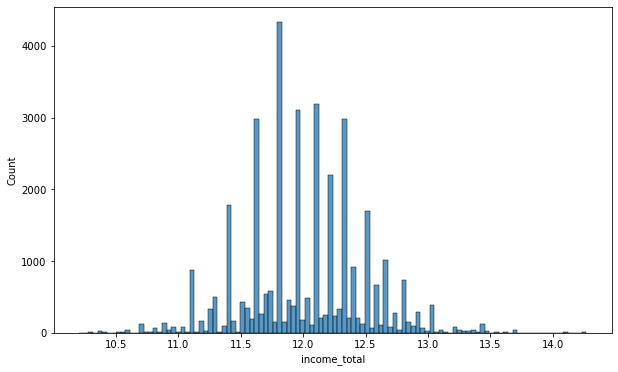

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(data['income_total'])

In [24]:
data = data.drop(['FLAG_MOBIL'], axis=1)

In [25]:
data['DAYS_BIRTH'] = data['DAYS_BIRTH'].map(lambda x: -x/365)

In [26]:
data['begin_month'] = data['begin_month'].map(lambda x: -x/12)

In [27]:
data['DAYS_EMPLOYED'].describe()

count     36457.0000000000000000000000000000000000000
mean      59262.9355679293439607135951519012451171875
std      137651.3348588631197344511747360229492187500
min      -15713.0000000000000000000000000000000000000
25%       -3153.0000000000000000000000000000000000000
50%       -1552.0000000000000000000000000000000000000
75%        -408.0000000000000000000000000000000000000
max      365243.0000000000000000000000000000000000000
Name: DAYS_EMPLOYED, dtype: float64

<AxesSubplot:xlabel='DAYS_EMPLOYED'>

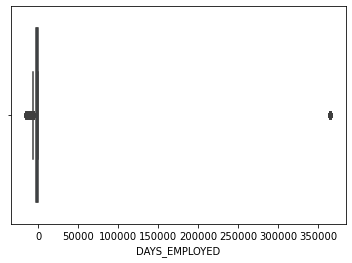

In [28]:
sns.boxplot(data['DAYS_EMPLOYED'])

In [29]:
data.loc[(data['DAYS_EMPLOYED'] > 0)]['income_type'].unique()

array(['Pensioner'], dtype=object)

In [32]:
data['DAYS_EMPLOYED'] = data_raw['DAYS_EMPLOYED']

In [33]:
data['DAYS_EMPLOYED']

0        -4709
1        -1540
2        -4434
3        -2092
4        -2105
         ...  
36452    -5434
36453    -1315
36454   -14018
36455    -1085
36456     -187
Name: DAYS_EMPLOYED, Length: 36457, dtype: int64

- 양수값은 모두 연금을 받는 사람들

In [34]:
data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].map(lambda x: -x if x < 0 else 0)

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='Count'>

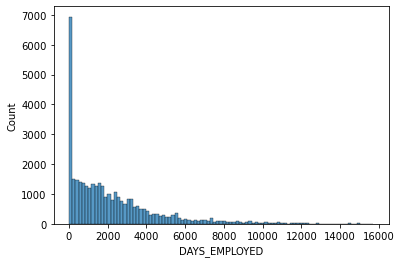

In [35]:
sns.histplot(data['DAYS_EMPLOYED'])

In [36]:
# Categorical data One-Hot Encoding, 데이터 타입은 string 타입이어야 한다.
data = pd.get_dummies(data, columns=['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type'])

In [37]:
data.shape

(36457, 55)

In [38]:
data.head()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,gender_F,...,occyp_type_Low-skill Laborers,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_NaN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,0,12.2185001037881431074083593557588756084442138...,38.0794520547945225530384050216525793075561523...,4709,0,0,0,2.0,0.50000000000000000000000000000000000000000000...,1,...,0,0,0,1,0,0,0,0,0,0
1,1,12.4191699013867609124872615211643278598785400...,31.1780821917808204091215884545817971229553222...,1540,0,0,1,3.0,0.41666666666666668517038374375260900706052780...,1,...,0,0,0,0,0,0,0,0,0,0
2,0,13.0170050839662554409414951805956661701202392...,52.2931506849315042018133681267499923706054687...,4434,0,1,0,2.0,1.83333333333333325931846502498956397175788879...,0,...,0,1,0,0,0,0,0,0,0,0
3,0,12.2185001037881431074083593557588756084442138...,41.3369863013698619624847196973860263824462890...,2092,0,1,0,2.0,3.08333333333333348136306995002087205648422241...,1,...,0,0,0,0,0,0,1,0,0,0
4,0,11.9671870864340181839224896975792944431304931...,41.1972602739726028175937244668602943420410156...,2105,0,0,0,2.0,2.16666666666666651863693004997912794351577758...,1,...,0,1,0,0,0,0,0,0,0,0


In [39]:
X_train = data[:len(train)]
X_test = data[len(train):].reset_index(drop=True)

In [40]:
print(X_train.shape)
print(X_test.shape)

(26457, 55)
(10000, 55)


In [41]:
X_train.to_pickle('./data/X_train_ver3.pkl')

In [46]:
X_test.to_pickle('./data/X_test_ver3.pkl')

In [42]:
y_train.to_pickle('./data/y_train_ver3.pkl')

# Test

In [47]:
X_train = pd.read_pickle('./data/X_train_ver3.pkl')

In [48]:
X_test = pd.read_pickle('./data/X_test_ver3.pkl')

In [59]:
y_train = pd.read_pickle('./data/y_train_ver3.pkl')

In [61]:
# 스코어 계산 함수
def get_scores(model, train, y):

    X_train, X_valid, y_train, y_valid = train_test_split(train, y, random_state=random_state, test_size=0.1)
    model.fit(X_train, y_train, 
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              early_stopping_rounds=50, 
              verbose=100)
    y_pred = model.predict_proba(X_valid)
    df = log_loss(y_valid, y_pred)
    
    return df

In [62]:
lgbm = lgb.LGBMClassifier(n_estimators=1000)

In [63]:
get_scores(lgbm, X_train, y_train)

Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.656597	valid_1's multi_logloss: 0.749291
[200]	training's multi_logloss: 0.57655	valid_1's multi_logloss: 0.731288
[300]	training's multi_logloss: 0.514511	valid_1's multi_logloss: 0.726628
Early stopping, best iteration is:
[341]	training's multi_logloss: 0.492673	valid_1's multi_logloss: 0.725266


0.7252656994728335

# Optuna를 이용한 Hyperparameter 최적화

In [79]:
def objective(trial):

    train_x, test_x, train_y, test_y = train_test_split(X_train, y_train, random_state=random_state, test_size=0.2)
    dtrain = lgb.Dataset(train_x, label=train_y)
    dval = lgb.Dataset(test_x, label=test_y)
 
    params = {
        'objective': 'multiclass',
        'num_class': 3,
        'metric': 'multi_logloss',
        'force_row_wise': True,
        'random_state': random_state,
        'early_stopping_round': 50,
        'verbose': -1,
#         'num_threads': 16,
        'tree_learner': 'voting',
        'boosting': 'gbdt',
#         'boosting': trial.suggest_categorical('boosting', ['gbdt', 'dart']),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.03),
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 31, 511),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 0.7),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 11),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 64),
    }
 
    gbm = lgb.train(params, dtrain, 2000, dval, verbose_eval=500)
    preds = gbm.predict(test_x)
    accuracy = log_loss(test_y, preds)
    
    return accuracy

In [80]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Best Value:', study.best_value)
print('Best trial:', study.best_trial.params)

[I 2021-04-25 22:09:21,638] A new study created in memory with name: no-name-4121669a-8216-47f7-b418-7c5139fbfe5d


Training until validation scores don't improve for 50 rounds
[500]	valid_0's multi_logloss: 0.720964
Early stopping, best iteration is:
[710]	valid_0's multi_logloss: 0.716794


[I 2021-04-25 22:09:28,876] Trial 0 finished with value: 0.7167936257849254 and parameters: {'learning_rate': 0.019870260648584884, 'num_leaves': 108, 'feature_fraction': 0.49687929542446774, 'bagging_fraction': 0.7004495684521482, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 0 with value: 0.7167936257849254.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's multi_logloss: 0.717564
Early stopping, best iteration is:
[560]	valid_0's multi_logloss: 0.717423


[I 2021-04-25 22:09:38,436] Trial 1 finished with value: 0.7174226360603919 and parameters: {'learning_rate': 0.02008951478859105, 'num_leaves': 207, 'feature_fraction': 0.3578875778832408, 'bagging_fraction': 0.9435123574057294, 'bagging_freq': 10, 'min_child_samples': 32}. Best is trial 0 with value: 0.7167936257849254.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's multi_logloss: 0.724208
Early stopping, best iteration is:
[552]	valid_0's multi_logloss: 0.723692


[I 2021-04-25 22:09:49,364] Trial 2 finished with value: 0.723691722816271 and parameters: {'learning_rate': 0.01666850128392377, 'num_leaves': 389, 'feature_fraction': 0.5353903875905509, 'bagging_fraction': 0.9333031208870812, 'bagging_freq': 2, 'min_child_samples': 64}. Best is trial 0 with value: 0.7167936257849254.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's multi_logloss: 0.710723
Early stopping, best iteration is:
[490]	valid_0's multi_logloss: 0.71066


[I 2021-04-25 22:10:00,715] Trial 3 finished with value: 0.7106602185671705 and parameters: {'learning_rate': 0.014586935384537909, 'num_leaves': 301, 'feature_fraction': 0.37888773054685226, 'bagging_fraction': 0.7324217849997937, 'bagging_freq': 1, 'min_child_samples': 13}. Best is trial 3 with value: 0.7106602185671705.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's multi_logloss: 0.727174
Early stopping, best iteration is:
[761]	valid_0's multi_logloss: 0.721349


[I 2021-04-25 22:10:18,346] Trial 4 finished with value: 0.7213485064008577 and parameters: {'learning_rate': 0.010825268801453371, 'num_leaves': 448, 'feature_fraction': 0.4878497058318034, 'bagging_fraction': 0.9777849421323401, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 3 with value: 0.7106602185671705.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[439]	valid_0's multi_logloss: 0.725178


[I 2021-04-25 22:10:25,999] Trial 5 finished with value: 0.725177905337968 and parameters: {'learning_rate': 0.0266735997985797, 'num_leaves': 288, 'feature_fraction': 0.365090095394893, 'bagging_fraction': 0.749186054153321, 'bagging_freq': 8, 'min_child_samples': 50}. Best is trial 3 with value: 0.7106602185671705.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[280]	valid_0's multi_logloss: 0.710749


[I 2021-04-25 22:10:37,104] Trial 6 finished with value: 0.7107491378328881 and parameters: {'learning_rate': 0.0223724744517544, 'num_leaves': 470, 'feature_fraction': 0.3140653795401817, 'bagging_fraction': 0.930490705204175, 'bagging_freq': 2, 'min_child_samples': 6}. Best is trial 3 with value: 0.7106602185671705.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[268]	valid_0's multi_logloss: 0.71169


[I 2021-04-25 22:10:46,975] Trial 7 finished with value: 0.7116903402447124 and parameters: {'learning_rate': 0.015385673362585381, 'num_leaves': 405, 'feature_fraction': 0.6716064896120247, 'bagging_fraction': 0.7278102890539477, 'bagging_freq': 6, 'min_child_samples': 2}. Best is trial 3 with value: 0.7106602185671705.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's multi_logloss: 0.719774
Early stopping, best iteration is:
[484]	valid_0's multi_logloss: 0.719364


[I 2021-04-25 22:10:52,102] Trial 8 finished with value: 0.7193644257280205 and parameters: {'learning_rate': 0.02626788717776523, 'num_leaves': 118, 'feature_fraction': 0.6930747391353976, 'bagging_fraction': 0.9655024198886808, 'bagging_freq': 11, 'min_child_samples': 18}. Best is trial 3 with value: 0.7106602185671705.


Training until validation scores don't improve for 50 rounds
[500]	valid_0's multi_logloss: 0.736391
[1000]	valid_0's multi_logloss: 0.722692
Early stopping, best iteration is:
[1093]	valid_0's multi_logloss: 0.721636


[I 2021-04-25 22:10:59,478] Trial 9 finished with value: 0.7216360959098835 and parameters: {'learning_rate': 0.019256249384504202, 'num_leaves': 59, 'feature_fraction': 0.5726373604543189, 'bagging_fraction': 0.7391342657160274, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 3 with value: 0.7106602185671705.


Best Value: 0.7106602185671705
Best trial: {'learning_rate': 0.014586935384537909, 'num_leaves': 301, 'feature_fraction': 0.37888773054685226, 'bagging_fraction': 0.7324217849997937, 'bagging_freq': 1, 'min_child_samples': 13}


In [81]:
study.trials_dataframe().sort_values(['value']).head(20)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_learning_rate,params_min_child_samples,params_num_leaves,state
3,3,0.71066021856717054294705349093419499695301055...,2021-04-25 22:09:49.365956,2021-04-25 22:10:00.714974,0 days 00:00:11.349018,0.73242178499979371242289971632999368011951446...,1,0.37888773054685226382432006175804417580366134...,0.01458693538453790898568041001226447406224906...,13,301,COMPLETE
6,6,0.71074913783288806712334917392581701278686523...,2021-04-25 22:10:26.000027,2021-04-25 22:10:37.104080,0 days 00:00:11.104053,0.93049070520417498375564946400118060410022735...,2,0.31406537954018171054926256147155072540044784...,0.02237247445175440108133813055246719159185886...,6,470,COMPLETE
7,7,0.71169034024471244936904668065835721790790557...,2021-04-25 22:10:37.105080,2021-04-25 22:10:46.975080,0 days 00:00:09.870000,0.72781028905394773431680732755921781063079833...,6,0.67160648961202473739007245967513881623744964...,0.01538567336258538087445657538410159759223461...,2,405,COMPLETE
0,0,0.71679362578492544777475359296659007668495178...,2021-04-25 22:09:21.639092,2021-04-25 22:09:28.876956,0 days 00:00:07.237864,0.70044956845214823015766114622238092124462127...,2,0.49687929542446773734098997010733000934123992...,0.01987026064858488441644546185216313460841774...,19,108,COMPLETE
1,1,0.71742263606039191614627270610071718692779541...,2021-04-25 22:09:28.877956,2021-04-25 22:09:38.436956,0 days 00:00:09.559000,0.94351235740572936272485549125121906399726867...,10,0.35788757788324082609321408199321012943983078...,0.02008951478859104938790025585149123799055814...,32,207,COMPLETE
8,8,0.71936442572802050676727958489209413528442382...,2021-04-25 22:10:46.975080,2021-04-25 22:10:52.101081,0 days 00:00:05.126001,0.96550241988868079623387075116625055670738220...,11,0.69307473913539763277213978653890080749988555...,0.02626788717776522980029696441306441556662321...,18,118,COMPLETE
4,4,0.72134850640085768080922434819513000547885894...,2021-04-25 22:10:00.716980,2021-04-25 22:10:18.345025,0 days 00:00:17.628045,0.97778494213234012910618275782326236367225646...,5,0.48784970583180342629248116281814873218536376...,0.01082526880145337142002937014240160351619124...,55,448,COMPLETE
9,9,0.72163609590988353481577632919652387499809265...,2021-04-25 22:10:52.102081,2021-04-25 22:10:59.478631,0 days 00:00:07.376550,0.73913426571602736103727693262044340372085571...,5,0.57263736045431889998269525676732882857322692...,0.01925624938450420237101567977333615999668836...,19,59,COMPLETE
2,2,0.72369172281627103249235233306535519659519195...,2021-04-25 22:09:38.436956,2021-04-25 22:09:49.363956,0 days 00:00:10.927000,0.93330312088708122786329113296233117580413818...,2,0.53539038759055090910266017090179957449436187...,0.01666850128392376867436652787546336185187101...,64,389,COMPLETE
5,5,0.72517790533796799845589475808083079755306243...,2021-04-25 22:10:18.346025,2021-04-25 22:10:25.999025,0 days 00:00:07.653000,0.74918605415332095720515326320310123264789581...,8,0.36509009539489301054970837867585942149162292...,0.02667359979857970159189406444966152776032686...,50,288,COMPLETE


In [82]:
study.best_params

{'learning_rate': 0.014586935384537909,
 'num_leaves': 301,
 'feature_fraction': 0.37888773054685226,
 'bagging_fraction': 0.7324217849997937,
 'bagging_freq': 1,
 'min_child_samples': 13}

In [83]:
study.best_value

0.7106602185671705

In [84]:
with open(f'./data/study_{study.best_value}.pkl', 'wb') as f:
    pickle.dump(study, f)

In [85]:
with open(f'./data/study_{study.best_value}.pkl', 'rb') as f:
    study = pickle.load(f)

In [86]:
params = study.best_params

In [87]:
params

{'learning_rate': 0.014586935384537909,
 'num_leaves': 301,
 'feature_fraction': 0.37888773054685226,
 'bagging_fraction': 0.7324217849997937,
 'bagging_freq': 1,
 'min_child_samples': 13}

In [88]:
lgbm = lgb.LGBMClassifier(**params, n_estimators=2000)

In [89]:
get_scores(lgbm, X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.37888773054685226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37888773054685226
[LightGBM] [Warning] bagging_fraction is set=0.7324217849997937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7324217849997937
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.686745	valid_1's multi_logloss: 0.773023
[200]	training's multi_logloss: 0.581127	valid_1's multi_logloss: 0.731307
[300]	training's multi_logloss: 0.508101	valid_1's multi_logloss: 0.71174
[400]	training's multi_logloss: 0.455977	valid_1's multi_logloss: 0.702923
[500]	training's multi_logloss: 0.412164	valid_1's multi_logloss: 0.700344
Early stopping, best iteration is:
[531]	training's multi_logloss: 0.398957	valid_1's multi_logloss: 0.700019


0.700019133079757

In [74]:
def ensemble_bagging(X_train, y_train, params, trials=5):
    
    train_x, test_x, train_y, test_y = train_test_split(X_train, y_train, random_state=random_state, test_size=0.1)
    
    prediction_list = []
    for _ in range(trials):
        data_index = [i for i in range(train_x.shape[0])]
        random_index = np.random.choice(data_index, train_x.shape[0], replace=True)
        
        gbm = lgb.LGBMClassifier(**params, n_estimators=2000)
        gbm.fit(train_x.iloc[random_index], train_y.iloc[random_index], eval_set=[(train_x, train_y), (test_x, test_y)], early_stopping_rounds=50, verbose=100)
        preds = gbm.predict_proba(X_test)
        
        prediction_list.append(preds)
        
    return prediction_list

In [76]:
def save_submission(X_train, y_train, study, split=5):
    param = study.best_params
    
    loss_list = []
    
    # StraifiedKFold
    skf = StratifiedKFold(n_splits=split, shuffle=True, random_state=42)
    folds=[]
    for train_idx, val_idx in skf.split(X_train, y_train):
        folds.append((train_idx, val_idx))

    lgb_models={}
    for fold in range(split):
        print(f'===================================={fold+1}============================================')
        train_idx, val_idx = folds[fold]
        train_x, val_x, train_y, val_y = X_train.iloc[train_idx].values, X_train.iloc[val_idx].values,\
                                             y_train[train_idx].values, y_train[val_idx].values 
        lgbm = lgb.LGBMClassifier(**param, n_estimators=2000)
        lgbm.fit(train_x, train_y, 
                eval_set=[(train_x, train_y), (val_x, val_y)], 
                early_stopping_rounds=50,
               verbose=200)
        pred = lgbm.predict_proba(val_x)
        loss_list.append(log_loss(val_y, pred))
        lgb_models[fold]=lgbm
        print(f'================================================================================\n\n')
        
    submission.iloc[:,1:] = 0
    mean_loss = np.mean(loss_list)
    print(f'mean loss : {mean_loss}')
    
    for fold in range(split):
        submission.iloc[:,1:] += lgb_models[fold].predict_proba(X_test)/split
    
    return submission, mean_loss

In [90]:
submission, mean_loss = save_submission(X_train, y_train, study, split=5)

====================================1============================================
[LightGBM] [Warning] feature_fraction is set=0.37888773054685226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37888773054685226
[LightGBM] [Warning] bagging_fraction is set=0.7324217849997937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7324217849997937
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 50 rounds
[200]	training's multi_logloss: 0.570214	valid_1's multi_logloss: 0.73203
[400]	training's multi_logloss: 0.441147	valid_1's multi_logloss: 0.701162
[600]	training's multi_logloss: 0.358826	valid_1's multi_logloss: 0.696786
Early stopping, best iteration is:
[584]	training's multi_logloss: 0.36345	valid_1's multi_logloss: 0.69657


====================================2============================================
[LightGBM] [Warning] feature_f

In [91]:
submission

,index,0,1,2
0,26457,0.06647676208046805756968211653656908310949802...,0.11323757219218580361008719137316802516579627...,0.82028566572734618045359411553363315761089324...
1,26458,0.23604783786774582998724270055390661582350730...,0.20479184057796442908205847288627410307526588...,0.55916032155428985195300128907547332346439361...
2,26459,0.04391536461080468994877534782972361426800489...,0.08901996561039240973833841508167097344994544...,0.86706466977880292112956794881029054522514343...
3,26460,0.11437604038783974469417614727717591449618339...,0.13498302832558631281223426867654779925942420...,0.75064093128657394249358958404627628624439239...
4,26461,0.05177696915501377866730692289820581208914518...,0.17458874901041743221696833643363788723945617...,0.77363428183456872666567960550310090184211730...
...,...,...,...,...
9995,36452,0.09445052941739916219088257776093087159097194...,0.30211195664150303219486204397981055080890655...,0.60343751394109790275877003296045586466789245...
9996,36453,0.31985201155877723833143022602598648518323898...,0.30474373659052139684533244690101128071546554...,0.37540425185070136482323732707300223410129547...
9997,36454,0.02554770903822222577472800253417517524212598...,0.07522923148825531869388072436777292750775814...,0.89922305947352243471470956137636676430702209...
9998,36455,0.13138422620984535615917820905451662838459014...,0.29025806170353407598128114841529168188571929...,0.57835771208662056785954064253019168972969055...


In [92]:
# submission 파일로 저장
submission.to_csv(f'./data/submission_2104015_{mean_loss}.csv', index=False)